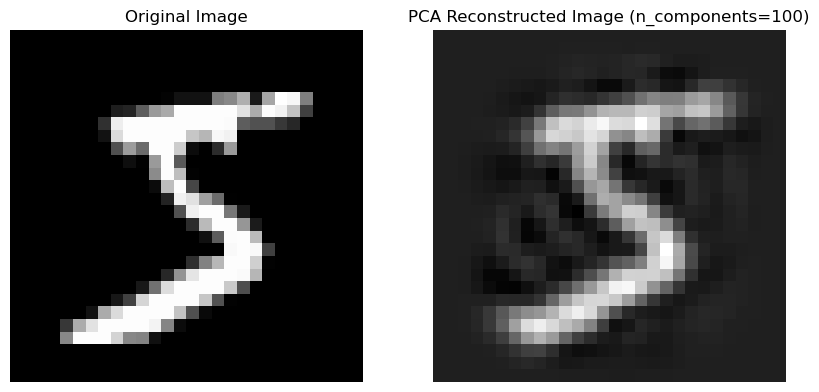

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test
from federated_learning import distribute_global_model, federated_averaging

# Initialization

In [2]:
# Predefined stuff

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
print((train_loader.dataset))

Dataset MNIST
    Number of datapoints: 60000
    Root location: /files/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [5]:
# get their respective data

train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [6]:
# PCA DR, later encapsulate this shit
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 


train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.1307) / 0.3081

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)


In [7]:
trainingset_pca = train_loader_reduced_pca.dataset

print(trainingset_pca.targets)

tensor([4, 8, 8,  ..., 7, 0, 8])


In [8]:
# Autoencoder initialization, does take time because the Autoencoder has to be trained first. Later maybe store the parameters.
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")


Epoch [1/5], Loss: 0.5416226983070374
Epoch [2/5], Loss: 0.5194114446640015
Epoch [3/5], Loss: 0.49051034450531006
Epoch [4/5], Loss: 0.5196213126182556
Epoch [5/5], Loss: 0.5136297345161438


In [9]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)


In [10]:
# Now partition them into 4 clients for federated learning
# pca 4 clients
trainingset_pca = train_loader_reduced_pca.dataset
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=4, alpha=0.5)
# Check sizes

for i in partitioned_data_pca:
    print(len(partitioned_data_pca[i]))

13622
9683
19121
17574


In [11]:
pca_client_loaders = [
    DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_pca.values()
]

In [12]:
x = pca_client_loaders[0].dataset
for i in range(len(x)):
    sample, label = x[i]
    print(f"Sample {i} shape: {sample.shape}, Label: {label}")

Sample 0 shape: torch.Size([1, 28, 28]), Label: 6
Sample 1 shape: torch.Size([1, 28, 28]), Label: 4
Sample 2 shape: torch.Size([1, 28, 28]), Label: 0
Sample 3 shape: torch.Size([1, 28, 28]), Label: 3
Sample 4 shape: torch.Size([1, 28, 28]), Label: 2
Sample 5 shape: torch.Size([1, 28, 28]), Label: 5
Sample 6 shape: torch.Size([1, 28, 28]), Label: 5
Sample 7 shape: torch.Size([1, 28, 28]), Label: 6
Sample 8 shape: torch.Size([1, 28, 28]), Label: 3
Sample 9 shape: torch.Size([1, 28, 28]), Label: 0
Sample 10 shape: torch.Size([1, 28, 28]), Label: 0
Sample 11 shape: torch.Size([1, 28, 28]), Label: 8
Sample 12 shape: torch.Size([1, 28, 28]), Label: 9
Sample 13 shape: torch.Size([1, 28, 28]), Label: 0
Sample 14 shape: torch.Size([1, 28, 28]), Label: 0
Sample 15 shape: torch.Size([1, 28, 28]), Label: 0
Sample 16 shape: torch.Size([1, 28, 28]), Label: 7
Sample 17 shape: torch.Size([1, 28, 28]), Label: 9
Sample 18 shape: torch.Size([1, 28, 28]), Label: 0
Sample 19 shape: torch.Size([1, 28, 28]),

In [13]:
# autoencoder 4 clients
# classic
trainingset = train_loader.dataset
partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=4, alpha=0.5)

for i in partitioned_data_classic:
    print(len(partitioned_data_classic[i]))

13622
9683
19121
17574


In [14]:
classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

In [15]:
# auto 4 clients
trainingset_auto = reduced_train_loader_auto.dataset
print(trainingset_auto.targets)
print(trainingset_auto.data.shape)
partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=4, alpha=0.5)
# Check sizes

for i in partitioned_data_auto:
    print(len(partitioned_data_auto[i]))

tensor([2, 0, 9,  ..., 9, 6, 0])
torch.Size([60000, 1, 28, 28])
13622
9683
19121
17574


In [16]:
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

In [17]:
# defining model for pca and autoencoder

global_model_pca = classification_model()
global_model_auto = classification_model()
gloabl_model_classic =classification_model()

num_clients = 4
# classic models
local_models_classic = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]
# pca models 
local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]
# autoencodere models
local_model_autoencoder = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

# Classic

In [22]:
rounds_classic = 4

for round_idx in range(rounds_classic):
    
    print(f"Round {round_idx + 1}/{rounds_classic}")

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        
    print(f"after training{local_models_classic}")
    global_weights_classic = federated_averaging(local_weights_classic)
    print(f"after fedaveraging{local_models_classic}")

    distribute_global_model(global_weights_classic,local_models_classic,single=False)

    distribute_global_model(global_weights_classic,gloabl_model_classic,single=True)
    test_losses = []
    test(gloabl_model_classic,test_loader,test_losses)


Round 1/4
Training client 1
Train Epoch: 1 [0/13622 (0%)]	Loss: 0.220551


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/13622 (5%)]	Loss: 0.248203
Train Epoch: 1 [1280/13622 (9%)]	Loss: 0.183767
Train Epoch: 1 [1920/13622 (14%)]	Loss: 0.417773
Train Epoch: 1 [2560/13622 (19%)]	Loss: 0.567334
Train Epoch: 1 [3200/13622 (23%)]	Loss: 0.143974
Train Epoch: 1 [3840/13622 (28%)]	Loss: 0.206935
Train Epoch: 1 [4480/13622 (33%)]	Loss: 0.455163
Train Epoch: 1 [5120/13622 (38%)]	Loss: 0.203771
Train Epoch: 1 [5760/13622 (42%)]	Loss: 0.161226
Train Epoch: 1 [6400/13622 (47%)]	Loss: 0.331346
Train Epoch: 1 [7040/13622 (52%)]	Loss: 0.183141
Train Epoch: 1 [7680/13622 (56%)]	Loss: 0.302162
Train Epoch: 1 [8320/13622 (61%)]	Loss: 0.194781
Train Epoch: 1 [8960/13622 (66%)]	Loss: 0.270769
Train Epoch: 1 [9600/13622 (70%)]	Loss: 0.294556
Train Epoch: 1 [10240/13622 (75%)]	Loss: 0.322810
Train Epoch: 1 [10880/13622 (80%)]	Loss: 0.391320
Train Epoch: 1 [11520/13622 (85%)]	Loss: 0.133799
Train Epoch: 1 [12160/13622 (89%)]	Loss: 0.391347
Train Epoch: 1 [12800/13622 (94%)]	Loss: 0.411751
Train Epoch: 1 [13

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1244, Accuracy: 9609/10000 (96%)

Round 2/4
Training client 1
Train Epoch: 1 [0/13622 (0%)]	Loss: 0.192232
Train Epoch: 1 [640/13622 (5%)]	Loss: 0.323188
Train Epoch: 1 [1280/13622 (9%)]	Loss: 0.229525
Train Epoch: 1 [1920/13622 (14%)]	Loss: 0.228463
Train Epoch: 1 [2560/13622 (19%)]	Loss: 0.134246
Train Epoch: 1 [3200/13622 (23%)]	Loss: 0.246625
Train Epoch: 1 [3840/13622 (28%)]	Loss: 0.207193
Train Epoch: 1 [4480/13622 (33%)]	Loss: 0.175213
Train Epoch: 1 [5120/13622 (38%)]	Loss: 0.159951
Train Epoch: 1 [5760/13622 (42%)]	Loss: 0.272681
Train Epoch: 1 [6400/13622 (47%)]	Loss: 0.374027
Train Epoch: 1 [7040/13622 (52%)]	Loss: 0.249895
Train Epoch: 1 [7680/13622 (56%)]	Loss: 0.182192
Train Epoch: 1 [8320/13622 (61%)]	Loss: 0.288660
Train Epoch: 1 [8960/13622 (66%)]	Loss: 0.287617
Train Epoch: 1 [9600/13622 (70%)]	Loss: 0.321140
Train Epoch: 1 [10240/13622 (75%)]	Loss: 0.248372
Train Epoch: 1 [10880/13622 (80%)]	Loss: 0.254868
Train Epoch: 1 [11520/13622 (85%)]	Lo

# PCA

In [24]:


rounds_pca = 4

for round_idx in range(rounds_pca):
    
    print(f"Round {round_idx + 1}/{rounds_pca}")

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        
    print(f"after training{local_models_pca}")
    global_weights_pca = federated_averaging(local_weights_pca)
    print(f"after fedaveraging{local_models_pca}")

    distribute_global_model(global_weights_pca,local_models_pca,single=False)

    distribute_global_model(global_weights_pca,global_model_pca,single=True)
    test_losses = []
    test(global_model_pca,test_loader_pca,test_losses)


    


Round 1/4
Training client 1
Train Epoch: 1 [0/13622 (0%)]	Loss: 0.196960
Train Epoch: 1 [640/13622 (5%)]	Loss: 0.173516
Train Epoch: 1 [1280/13622 (9%)]	Loss: 0.181410
Train Epoch: 1 [1920/13622 (14%)]	Loss: 0.319798
Train Epoch: 1 [2560/13622 (19%)]	Loss: 0.288784
Train Epoch: 1 [3200/13622 (23%)]	Loss: 0.272949
Train Epoch: 1 [3840/13622 (28%)]	Loss: 0.223026
Train Epoch: 1 [4480/13622 (33%)]	Loss: 0.116764
Train Epoch: 1 [5120/13622 (38%)]	Loss: 0.254629
Train Epoch: 1 [5760/13622 (42%)]	Loss: 0.125898
Train Epoch: 1 [6400/13622 (47%)]	Loss: 0.111004
Train Epoch: 1 [7040/13622 (52%)]	Loss: 0.260258
Train Epoch: 1 [7680/13622 (56%)]	Loss: 0.548961
Train Epoch: 1 [8320/13622 (61%)]	Loss: 0.465923
Train Epoch: 1 [8960/13622 (66%)]	Loss: 0.264457
Train Epoch: 1 [9600/13622 (70%)]	Loss: 0.225454
Train Epoch: 1 [10240/13622 (75%)]	Loss: 0.127019
Train Epoch: 1 [10880/13622 (80%)]	Loss: 0.246301
Train Epoch: 1 [11520/13622 (85%)]	Loss: 0.479406
Train Epoch: 1 [12160/13622 (89%)]	Loss: 0.39

In [21]:
test = auto_client_loaders[0].dataset
for i in range(len(test)):
    sample, label = test[i]
    print(f"Sample {i} shape: {sample.shape}, Label: {label}")

Sample 0 shape: torch.Size([1, 28, 28]), Label: 6
Sample 1 shape: torch.Size([1, 28, 28]), Label: 4
Sample 2 shape: torch.Size([1, 28, 28]), Label: 0
Sample 3 shape: torch.Size([1, 28, 28]), Label: 3
Sample 4 shape: torch.Size([1, 28, 28]), Label: 2
Sample 5 shape: torch.Size([1, 28, 28]), Label: 5
Sample 6 shape: torch.Size([1, 28, 28]), Label: 5
Sample 7 shape: torch.Size([1, 28, 28]), Label: 6
Sample 8 shape: torch.Size([1, 28, 28]), Label: 3
Sample 9 shape: torch.Size([1, 28, 28]), Label: 0
Sample 10 shape: torch.Size([1, 28, 28]), Label: 0
Sample 11 shape: torch.Size([1, 28, 28]), Label: 8
Sample 12 shape: torch.Size([1, 28, 28]), Label: 9
Sample 13 shape: torch.Size([1, 28, 28]), Label: 0
Sample 14 shape: torch.Size([1, 28, 28]), Label: 0
Sample 15 shape: torch.Size([1, 28, 28]), Label: 0
Sample 16 shape: torch.Size([1, 28, 28]), Label: 7
Sample 17 shape: torch.Size([1, 28, 28]), Label: 9
Sample 18 shape: torch.Size([1, 28, 28]), Label: 0
Sample 19 shape: torch.Size([1, 28, 28]),

# Autoencoder

In [ ]:
print(len(auto_client_loaders[0].dataset))


13622


AttributeError: 'DataLoader' object has no attribute 'data'

In [18]:
test_optimizer = optim.SGD(local_model_autoencoder[0].parameters(), lr=learning_rate,
                      momentum=momentum)
        
test_train_losses = []
test_train_counter = []
train(n_epochs, local_model_autoencoder[0], auto_client_loaders[0], test_optimizer, log_interval, test_train_losses, test_train_counter)

Train Epoch: 3 [0/13622 (0%)]	Loss: 2.358995
Train Epoch: 3 [640/13622 (5%)]	Loss: 2.331650


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 3 [1280/13622 (9%)]	Loss: 2.295540
Train Epoch: 3 [1920/13622 (14%)]	Loss: 2.273618
Train Epoch: 3 [2560/13622 (19%)]	Loss: 2.244627
Train Epoch: 3 [3200/13622 (23%)]	Loss: 2.220072
Train Epoch: 3 [3840/13622 (28%)]	Loss: 2.184708
Train Epoch: 3 [4480/13622 (33%)]	Loss: 2.207809
Train Epoch: 3 [5120/13622 (38%)]	Loss: 2.073591
Train Epoch: 3 [5760/13622 (42%)]	Loss: 2.188975
Train Epoch: 3 [6400/13622 (47%)]	Loss: 2.088592
Train Epoch: 3 [7040/13622 (52%)]	Loss: 2.203930
Train Epoch: 3 [7680/13622 (56%)]	Loss: 2.026757
Train Epoch: 3 [8320/13622 (61%)]	Loss: 1.846286
Train Epoch: 3 [8960/13622 (66%)]	Loss: 2.101042
Train Epoch: 3 [9600/13622 (70%)]	Loss: 2.031491
Train Epoch: 3 [10240/13622 (75%)]	Loss: 1.981588
Train Epoch: 3 [10880/13622 (80%)]	Loss: 1.806795
Train Epoch: 3 [11520/13622 (85%)]	Loss: 1.717346
Train Epoch: 3 [12160/13622 (89%)]	Loss: 1.602375
Train Epoch: 3 [12800/13622 (94%)]	Loss: 1.500884
Train Epoch: 3 [13440/13622 (99%)]	Loss: 1.673114


In [21]:
rounds_auto = 4

for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")

    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)
        
        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
        
    global_weights_auto = federated_averaging(local_weights_auto)

    distribute_global_model(global_weights_auto,local_model_autoencoder,single=False)

    distribute_global_model(global_weights_auto, global_model_auto,single=True)
    test_losses = []
    test(global_model_auto,test_loader_auto,test_losses)

Round 1/4
Training client 1
Train Epoch: 1 [0/13622 (0%)]	Loss: 0.433944
Train Epoch: 1 [640/13622 (5%)]	Loss: 0.661617
Train Epoch: 1 [1280/13622 (9%)]	Loss: 0.496904


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/13622 (14%)]	Loss: 0.232057
Train Epoch: 1 [2560/13622 (19%)]	Loss: 0.397850
Train Epoch: 1 [3200/13622 (23%)]	Loss: 0.571911
Train Epoch: 1 [3840/13622 (28%)]	Loss: 0.382414
Train Epoch: 1 [4480/13622 (33%)]	Loss: 0.288490
Train Epoch: 1 [5120/13622 (38%)]	Loss: 0.507904
Train Epoch: 1 [5760/13622 (42%)]	Loss: 0.330656
Train Epoch: 1 [6400/13622 (47%)]	Loss: 0.367658
Train Epoch: 1 [7040/13622 (52%)]	Loss: 0.379698
Train Epoch: 1 [7680/13622 (56%)]	Loss: 0.401983
Train Epoch: 1 [8320/13622 (61%)]	Loss: 0.451965
Train Epoch: 1 [8960/13622 (66%)]	Loss: 0.392931
Train Epoch: 1 [9600/13622 (70%)]	Loss: 0.495193
Train Epoch: 1 [10240/13622 (75%)]	Loss: 0.388923
Train Epoch: 1 [10880/13622 (80%)]	Loss: 0.165450
Train Epoch: 1 [11520/13622 (85%)]	Loss: 0.669341
Train Epoch: 1 [12160/13622 (89%)]	Loss: 0.437784
Train Epoch: 1 [12800/13622 (94%)]	Loss: 0.296081
Train Epoch: 1 [13440/13622 (99%)]	Loss: 0.563755
Train Epoch: 2 [0/13622 (0%)]	Loss: 0.417996
Train Epoch: 2 [64

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4766, Accuracy: 8606/10000 (86%)

Round 2/4
Training client 1
Train Epoch: 1 [0/13622 (0%)]	Loss: 0.739834
Train Epoch: 1 [640/13622 (5%)]	Loss: 0.624843
Train Epoch: 1 [1280/13622 (9%)]	Loss: 0.491728
Train Epoch: 1 [1920/13622 (14%)]	Loss: 0.515153
Train Epoch: 1 [2560/13622 (19%)]	Loss: 0.646139
Train Epoch: 1 [3200/13622 (23%)]	Loss: 0.501865
Train Epoch: 1 [3840/13622 (28%)]	Loss: 0.465664
Train Epoch: 1 [4480/13622 (33%)]	Loss: 0.657377
Train Epoch: 1 [5120/13622 (38%)]	Loss: 0.649015
Train Epoch: 1 [5760/13622 (42%)]	Loss: 0.533389
Train Epoch: 1 [6400/13622 (47%)]	Loss: 0.563770
Train Epoch: 1 [7040/13622 (52%)]	Loss: 0.564696
Train Epoch: 1 [7680/13622 (56%)]	Loss: 0.496373
Train Epoch: 1 [8320/13622 (61%)]	Loss: 0.481442
Train Epoch: 1 [8960/13622 (66%)]	Loss: 0.445896
Train Epoch: 1 [9600/13622 (70%)]	Loss: 0.517133
Train Epoch: 1 [10240/13622 (75%)]	Loss: 0.396619
Train Epoch: 1 [10880/13622 (80%)]	Loss: 0.432472
Train Epoch: 1 [11520/13622 (85%)]	Lo